In [1]:
import sklearn.datasets as skld
import matplotlib.pyplot as plt
import numpy as np
import torch

2.56515205023976e-05
0.005064733013930496


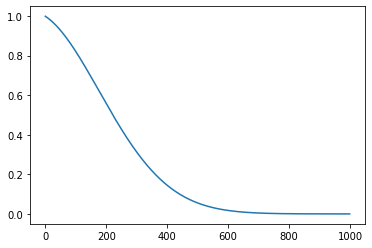

In [2]:
noise_schedule = np.linspace(0.001,0.02,1000)
print((1-noise_schedule).prod())
print((np.sqrt(1-noise_schedule)).prod())
plt.plot((1-noise_schedule).cumprod())

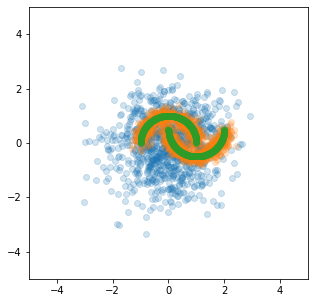

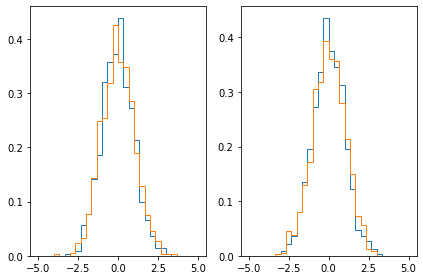

In [3]:
def corrupt(X,t):
    def _corrupt_step(X,var):
        alpha = 1-var
        X = np.random.normal(np.sqrt(alpha)*X,np.sqrt(1-alpha), size = X.shape)
        return X
    for step in range(t):
        X = _corrupt_step(X,noise_schedule[step])
    return torch.FloatTensor(X)

def make_data(N):
#     xi = np.linspace(-1,1)
#     yi = np.sin(4*xi)
#     X0 = np.column_stack([xi,yi])
#     X0a = torch.tensor([2.,2.]).repeat((N//3,1))
#     X0b = torch.tensor([-2.,2.]).repeat((N//3,1))
#     X0c = torch.tensor([0,4.]).repeat((N//3,1))
#     X0 = torch.cat([X0a,X0b,X0c],dim=0)
    X0,y = skld.make_moons(N)
    return torch.FloatTensor(X0)

X0 = make_data(1000)

X = corrupt(X0,len(noise_schedule))
plt.scatter(X[:,0],X[:,1], alpha = 0.2)


X = corrupt(X0,20)
plt.scatter(X[:,0],X[:,1], alpha = 0.2)

X = corrupt(X0,0)
plt.scatter(X[:,0],X[:,1], alpha = 0.2)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.gcf().set_size_inches(5,5)
plt.show()

X0 = make_data(1000)
X = corrupt(X0,len(noise_schedule))
bins = np.linspace(-5,5,31)
f,axarr = plt.subplots(1,2)
ax = axarr[0]
ax.hist(X[:,0], density=True, bins = bins, histtype = 'step');
ax.hist(np.random.normal(0,1,size = (1000,)), density=True, bins = bins, histtype = 'step');

ax = axarr[1]
ax.hist(X[:,1], density=True, bins = bins, histtype = 'step');
ax.hist(np.random.normal(0,1,size = (1000,)), density=True, bins = bins, histtype = 'step');
f.set_tight_layout(True)

In [4]:
import torch
make_model = lambda: torch.nn.Sequential(
    torch.nn.Linear(3,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,2),    
)

def make_Xt(X,t):
    tcol = torch.ones((X.shape[0],1))*(t/len(noise_schedule))
    Xt = torch.cat([X,tcol],dim=-1)
    return Xt
    
def train():   
    model = make_model()
    opt = torch.optim.Adam(model.parameters(),3e-4)
    for i in range(5000):
        X0 = make_data(500)
        t = np.random.randint(1,len(noise_schedule))
        X = corrupt(X0,t)
        Xt = make_Xt(X,t)

        pred = model(Xt)
        loss = torch.nn.functional.mse_loss(pred,X0)
        if i % 1000 == 0:
            print(i,float(loss))
        loss.backward()
        opt.step()
        opt.zero_grad()
    return model
        
print(make_Xt(make_data(100),len(noise_schedule))[:2])
trained_model = train()

tensor([[0.8713, 0.4907, 1.0000],
        [0.0509, 0.1849, 1.0000]])
0 0.6262432932853699
1000 0.49586421251296997
2000 0.371910035610199
3000 0.46844929456710815
4000 0.45123398303985596


(-5.0, 5.0)

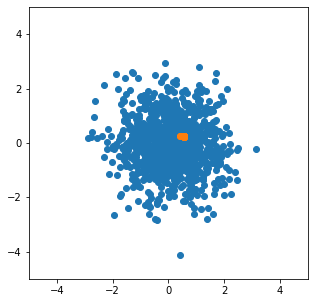

In [5]:
X0 = make_data(1000)
t = 1000
X = corrupt(X0,t)
Xt = make_Xt(X,t)
plt.scatter(X[:,0],X[:,1])

p = trained_model(Xt).detach()
plt.scatter(p[:,0],p[:,1])
plt.gcf().set_size_inches(5,5)
plt.xlim(-5,5)
plt.ylim(-5,5)

(-5.0, 5.0)

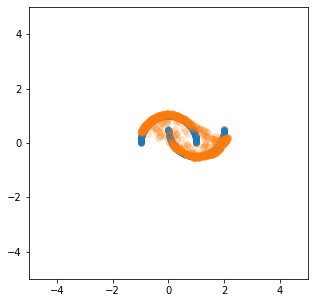

In [20]:
def get_mean_sigma(xt,x0,t):
    step = t
    alpha = 1-noise_schedule
    alpha_t = alpha[step]
    alphabar_t = alpha[:step].prod()

    alpha_t1 = alpha[step-1]
    alphabar_t1 = alpha[:step-1].prod()
    f1 = np.sqrt(alpha_t)*(1-alphabar_t1)/(1-alphabar_t)
    f2 = np.sqrt(alphabar_t1)*(1-alpha_t)/(1-alphabar_t)
    xmean = f1*xt + f2*x0
    sigma2 = (1-alphabar_t1)/(1-alphabar_t)*(1-alpha_t)
    return xmean,np.sqrt(sigma2)


def denoise_step(trained_model,X,t):
    Xt = make_Xt(X,t)
    with torch.no_grad():
        X0pred = trained_model(Xt)
    mean,sigma = get_mean_sigma(X,X0pred,t)
    Xt1 = mean + sigma*torch.randn(X.shape)
    return Xt1

def generate(trained_model,N,steps):
    X = torch.FloatTensor(np.random.normal(0,1,size = (N,2)))
    for i in range(1,steps):
        t = len(noise_schedule) - i
        X = denoise_step(trained_model,X,t)
    return X

X0 = make_data(1000)
plt.scatter(X0[:,0],X0[:,1], alpha = 0.2)
XG = generate(trained_model,1234,1000)
plt.scatter(XG[:,0],XG[:,1], alpha = 0.2)
plt.gcf().set_size_inches(5,5)
plt.xlim(-5,5)
plt.ylim(-5,5)

In [28]:
!open .